In [1]:
import qiskit
from qiskit import *
from qiskit.providers.fake_provider import FakeManilaV2
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from math import pi

In [2]:
import os

In [3]:
# Creating registers with n qubits
n =7  # for a local backend n can go as up as 23, after that it raises a Memory Error
qr = QuantumRegister(n, name='qr')
cr = ClassicalRegister(n, name='cr')

qc = QuantumCircuit(qr, cr, name='QC')

In [4]:
# Generate a random number in the range of available qubits [0,65536))
alice_key = np.random.randint(0,2**n)#here we can remplace by a key from a quantum key generator
alice_key = np.binary_repr(alice_key,n)

In [5]:
print(alice_key)

0011001


In [6]:
for i in range(len(alice_key)):
 if alice_key[i]=='1':
    qc.x(qr[i])

Alice Basis ['H', 'H', 'S', 'S', 'H', 'S', 'H']


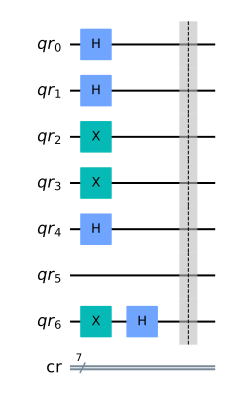

In [7]:
B=[]
for i in range(len(alice_key)):

 if 0.5 < np.random.random():
    qc.h(qr[i])
    B.append("H")
 else:
    B.append("S")
    pass
    
qc.barrier()  
print("Alice Basis",B)
%config InlineBackend.figure_format = 'svg'
qc.draw(output='mpl')

Bob Basis ['S', 'H', 'H', 'S', 'S', 'H', 'S']


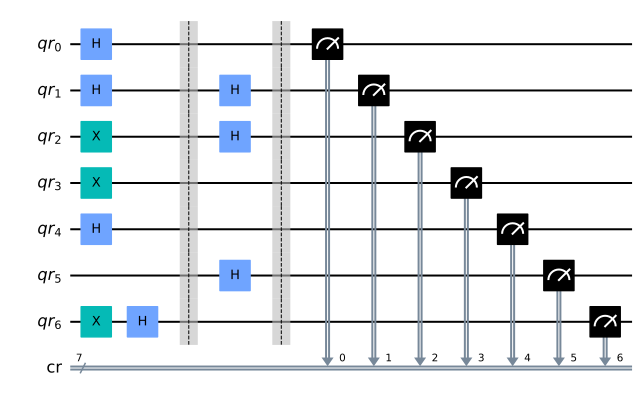

In [8]:
C=[]
for i in range(len(alice_key)):
 if 0.5 < np.random.random():
    qc.h(qr[i])
    C.append("H")
    
 else:
    C.append("S")
qc.barrier()
for i in range(len(alice_key)):
 qc.measure(qr[i],cr[i])
print("Bob Basis",C)
qc.draw(output='mpl')

In [9]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, backend = simulator, shots = 4096).result()
print("Bob key :",list(result.get_counts(qc))[0])
print("Bob Basis",C)

print("Alice key :",alice_key)
print("Alice Basis :",B)

Bob key : 0101101
Bob Basis ['S', 'H', 'H', 'S', 'S', 'H', 'S']
Alice key : 0011001
Alice Basis : ['H', 'H', 'S', 'S', 'H', 'S', 'H']


In [10]:
def sifted_key(A_basis,B_basis,key): 
 correct_basis=[]
 sifted_key=''

 for i in range(len(A_basis)):
  if A_basis[i]==B_basis[i]:
    correct_basis.append(i)
    sifted_key+=key[i]
  else:
    pass 
 return sifted_key,correct_basis
a=sifted_key(B,C,alice_key)
print("sifted key",a[0])
print("Basis",a[1])

sifted key 01
Basis [1, 3]


In [11]:
BB84_key=a[0]

In [12]:
def wordToBV(s) :
    #convert text to binary
    a_byte_array = bytearray(s, "utf8")
    byte_list = []


    for byte in a_byte_array:
        binary_representation = bin(byte)
        byte_list.append(binary_representation[9-n:])
        #chop off the "0b" at the beginning. can also truncate the binary to fit on a device with N qubits
        #binary has 2 extra digits for "0b", so it starts at 9 for our 7 bit operation. 

    print(byte_list)
    
    circuit_array = []
    
    length = len(byte_list) 
    
    for i in range(length):
    
        s = byte_list[i]


        #do all  this stuff for every letter

        # We need a circuit with n qubits, plus one ancilla qubit
        # Also need n classical bits to write the output to
        bv_circuit = QuantumCircuit(n+1, n)

        # put ancilla in state |->
        bv_circuit.h(n)
        bv_circuit.z(n)

        # Apply Hadamard gates before querying the oracle
        for i in range(n):
            bv_circuit.h(i)

        # Apply barrier 
        bv_circuit.barrier()

        # Apply the inner-product oracle
        s = s[::-1] # reverse s to fit qiskit's qubit ordering
        for q in range(n):
            if s[q] == '0':
                bv_circuit.i(q)
            else:
                bv_circuit.cx(q, n)

        # Apply barrier 
        bv_circuit.barrier()

        #Apply Hadamard gates after querying the oracle
        for i in range(n):
            bv_circuit.h(i)

        # Measurement
        for i in range(n):
            bv_circuit.measure(i, i)
            
        circuit_array.append(bv_circuit)

    
    return circuit_array

['1111000']


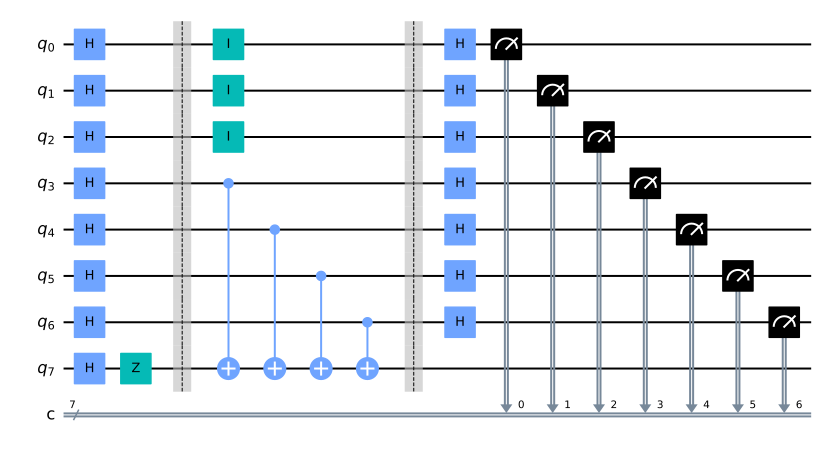

In [13]:
circuit_to_run = wordToBV('x')#Secret Msg
circuit_to_run[0].draw(output='mpl')

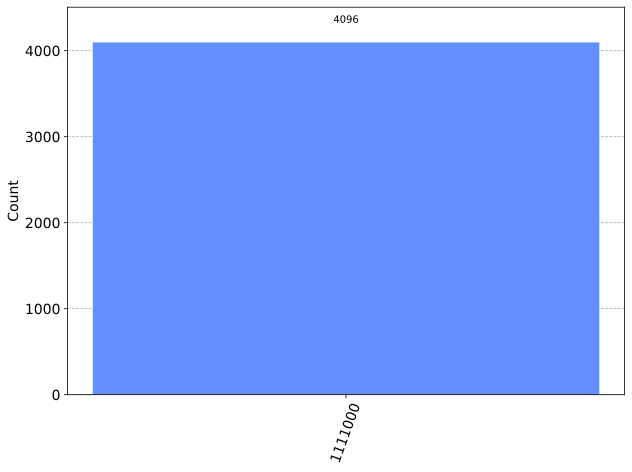

In [14]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 4096
results = execute(circuit_to_run[::-1], backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer,figsize=(10,7))

In [15]:
def encrypt(BB84_key, letter):
    """Calculates XOR"""
    b = int(BB84_key, 2)
    x = sum([ord(i) for i in letter])
    return format(b ^ x, "b")


def stega_encoder(LM, carrier_msg):
    """Encodes LM bits message into carrier_msg"""
    message = ""
    size = len(LM[0])
    i = 0
    for j, bitstring in enumerate(LM):
        for k, digit in enumerate(bitstring):
            while (not carrier_msg[i].isalpha()):
                message += carrier_msg[i]
                i += 1

            if digit == "1":
                letter = carrier_msg[i].upper()
                message += letter
            else:
                message += carrier_msg[i]

            i += 1
    
    if i < len(carrier_msg):
        message += carrier_msg[i:]

    return message


def stega_decoder(new_carrier_msg, BB84_key):
    """Decodes secret message from new_carrier_msg"""

    b = int(BB84_key, 2)

    message = ""
    bitstring = ""
    for char in new_carrier_msg:
        if char.isalpha():
            if char.isupper():
                bitstring += "1"
            else:
                bitstring += "0"

        if len(bitstring) == 7:
            x = int(bitstring, 2)
            message += chr(b ^ x)
            bitstring = ""

    return message

In [16]:
for i in range(100, 1100):
    carrier_msg=chr(i)

In [17]:
str(carrier_msg)

'ы'

In [18]:
en = encrypt(BB84_key,'bnmit')

In [19]:
secret_msg='bnmit'
L=[]
for c in secret_msg:
    L.append(encrypt(BB84_key,c))

In [20]:
carrier_msg='Bangalore is known as silicon city of india'

In [21]:
new_carrier_msg=stega_encoder(L, carrier_msg)

In [22]:
stega_decoder(new_carrier_msg, BB84_key)

'bnmit'